In [27]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
import scipy.spatial
import pickle

jax.config.update("jax_platform_name", "cpu")
import confirm.mini_imprint.lewis_drivers as lts
from confirm.mini_imprint import grid
import adastate
import diagnostics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from confirm.lewislib import lewis, batch

name = "4d_full"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

In [46]:
with open(f"./{name}/data_params.pkl", "rb") as f:
    P, D = pickle.load(f)
load_iter = "latest"
S, load_iter, fn = adastate.load(name, load_iter)

loading checkpoint 4d_full/3880.pkl


In [47]:
with open(f"./{name}/storage_0.075.pkl", "rb") as f:
    S_load = pickle.load(f)

In [48]:
S = adastate.AdaState(
    grid.concat_grids(S.g, S_load.g),
    np.concatenate((S.sim_sizes, S_load.sim_sizes), dtype=np.int32),
    np.concatenate((S.todo, S_load.todo), dtype=bool),
    adastate.TileDB(
        np.concatenate((S.db.data, S_load.db.data), dtype=np.float32), S.db.slices
    ),
)

In [49]:
worst_tile_idx = np.argmin(S.orig_lam)
worst_tile = S.g.theta_tiles[worst_tile_idx]

## Tile density

In [50]:
plot_dims = [2, 3]
slc = diagnostics.build_2d_slice(S.g, worst_tile, plot_dims)

In [70]:
theta_tiles2 = S.g.theta_tiles.copy()
theta_tiles2[:, 2] = S.g.theta_tiles[:, 3]
theta_tiles2[:, 3] = S.g.theta_tiles[:, 2]
sym_tiles1 = np.concatenate((S.g.theta_tiles, theta_tiles2))

theta_tiles3 = sym_tiles1.copy()
theta_tiles3[:, 1] = sym_tiles1[:, 2]
theta_tiles3[:, 2] = sym_tiles1[:, 1]
all_tiles = np.concatenate((sym_tiles1, theta_tiles3))

In [73]:
tree = scipy.spatial.KDTree(all_tiles)

In [94]:
nearby = tree.query_ball_point(slc.reshape((-1, 4)), 0.04)
nearby_count = [len(n) for n in nearby]

In [76]:
dist, idx = tree.query(slc.reshape((-1, 4)))

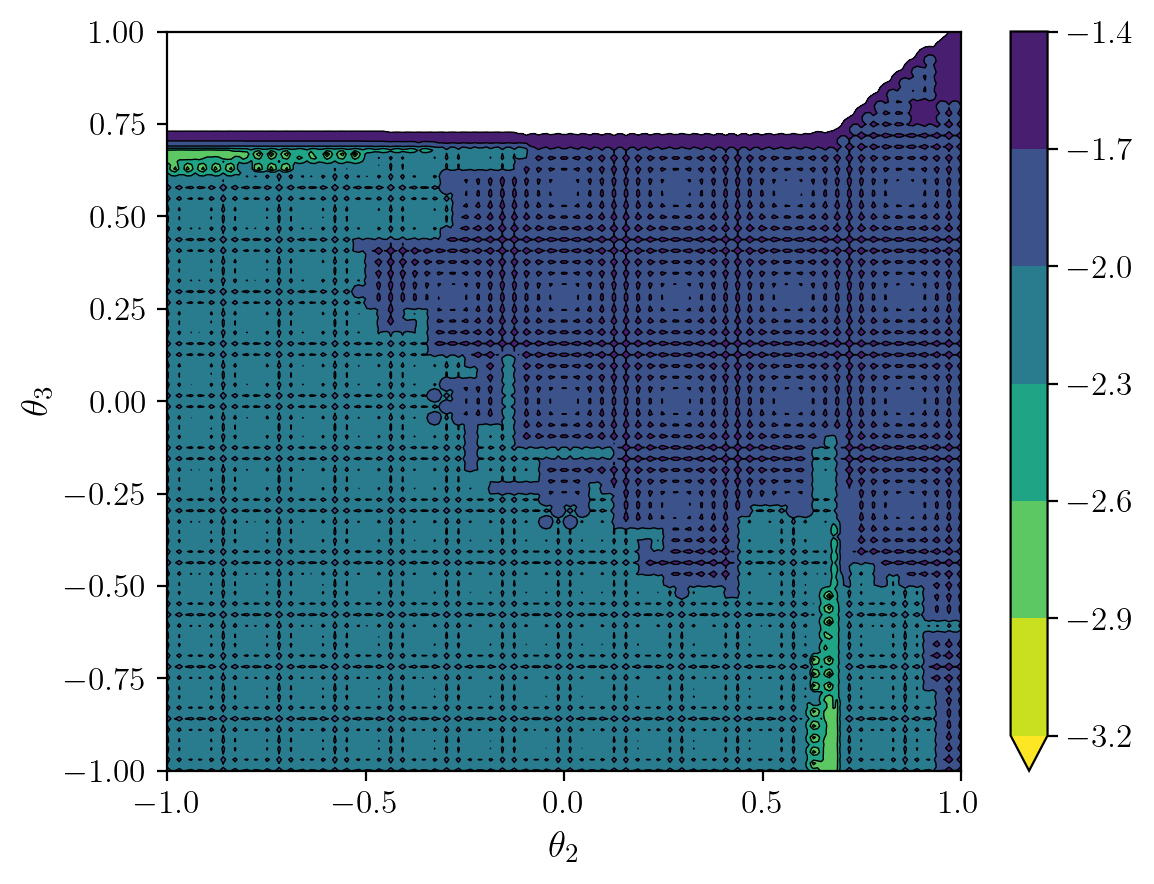

In [93]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = np.array(dist).reshape(slc.shape[:2])
z = np.log10(z)
levels = np.linspace(-3.2, -1.4, 7)
cntf = plt.contourf(x, y, z, levels=levels, cmap="viridis_r", extend="min")
plt.contour(
    x, y, z, levels=levels, colors="k", linestyles="-", linewidths=0.5, extend="min"
)
cbar = plt.colorbar(cntf)
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.show()

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_29688/616776376.py:5: RuntimeWarning: divide by zero encountered in log10
  z = np.log10(z)


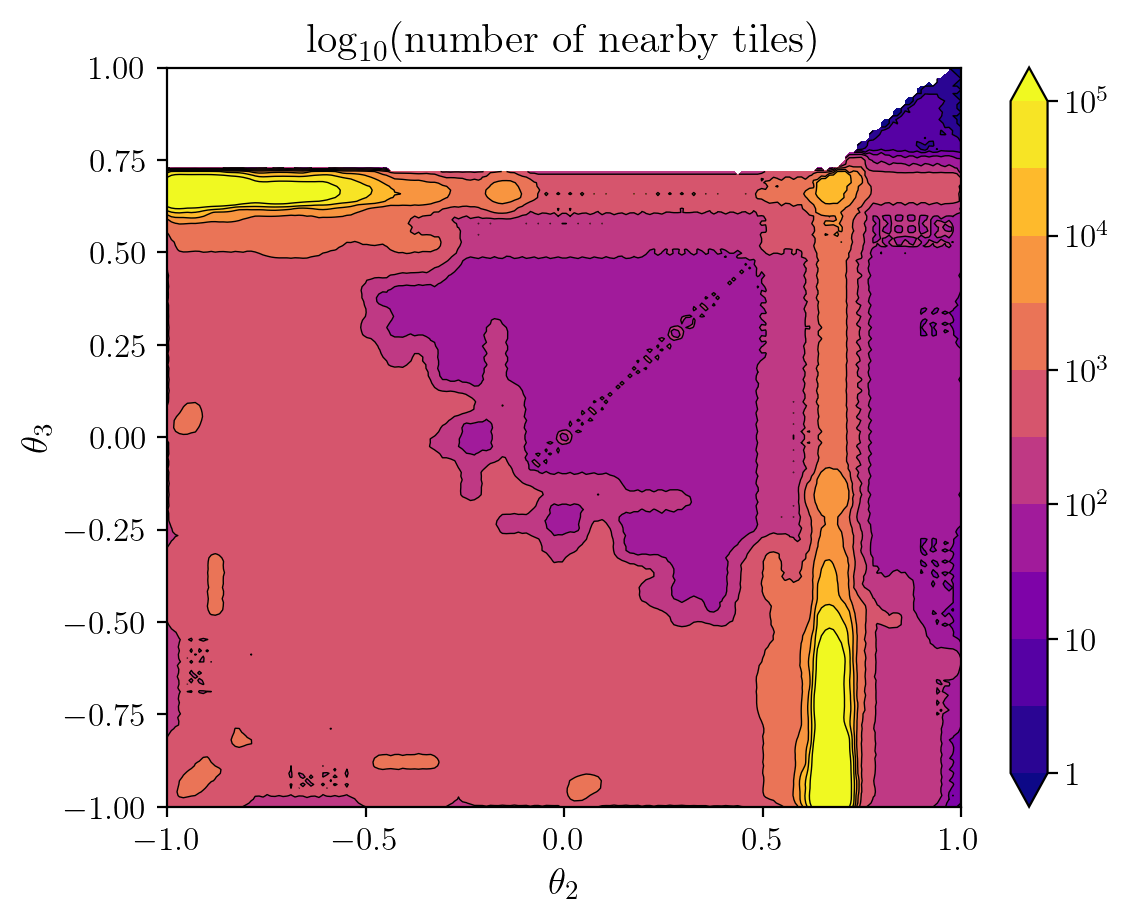

In [95]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = np.array(nearby_count).reshape(slc.shape[:2])
# z[z == 0] = z.T[z == 0]
z = np.log10(z)
levels = np.linspace(0, 5, 11)
plt.title("$\log_{10}$(number of nearby tiles)")
cntf = plt.contourf(x, y, z, levels=levels, extend="both")
plt.contour(
    x,
    y,
    z,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cntf, ticks=np.arange(6))
cbar.ax.set_yticklabels(["1", "10", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.show()

## Type I error

In [6]:
plot_dims = [1, 2]
slc = diagnostics.build_2d_slice(S.g, worst_tile, plot_dims)
slc_ravel = slc.reshape((-1, S.g.d))
nx, ny, _ = slc.shape
# tb = diagnostics.eval_bound(lei_obj, S.g, S.sim_sizes, D, slc_ravel)
# tb = tb.reshape((nx, ny))

In [7]:
# step 1: evaluate the field of interest. if it's lambda*, we already have what
# we need. if it's TIE, we need to calculate it for the relevant tiles.

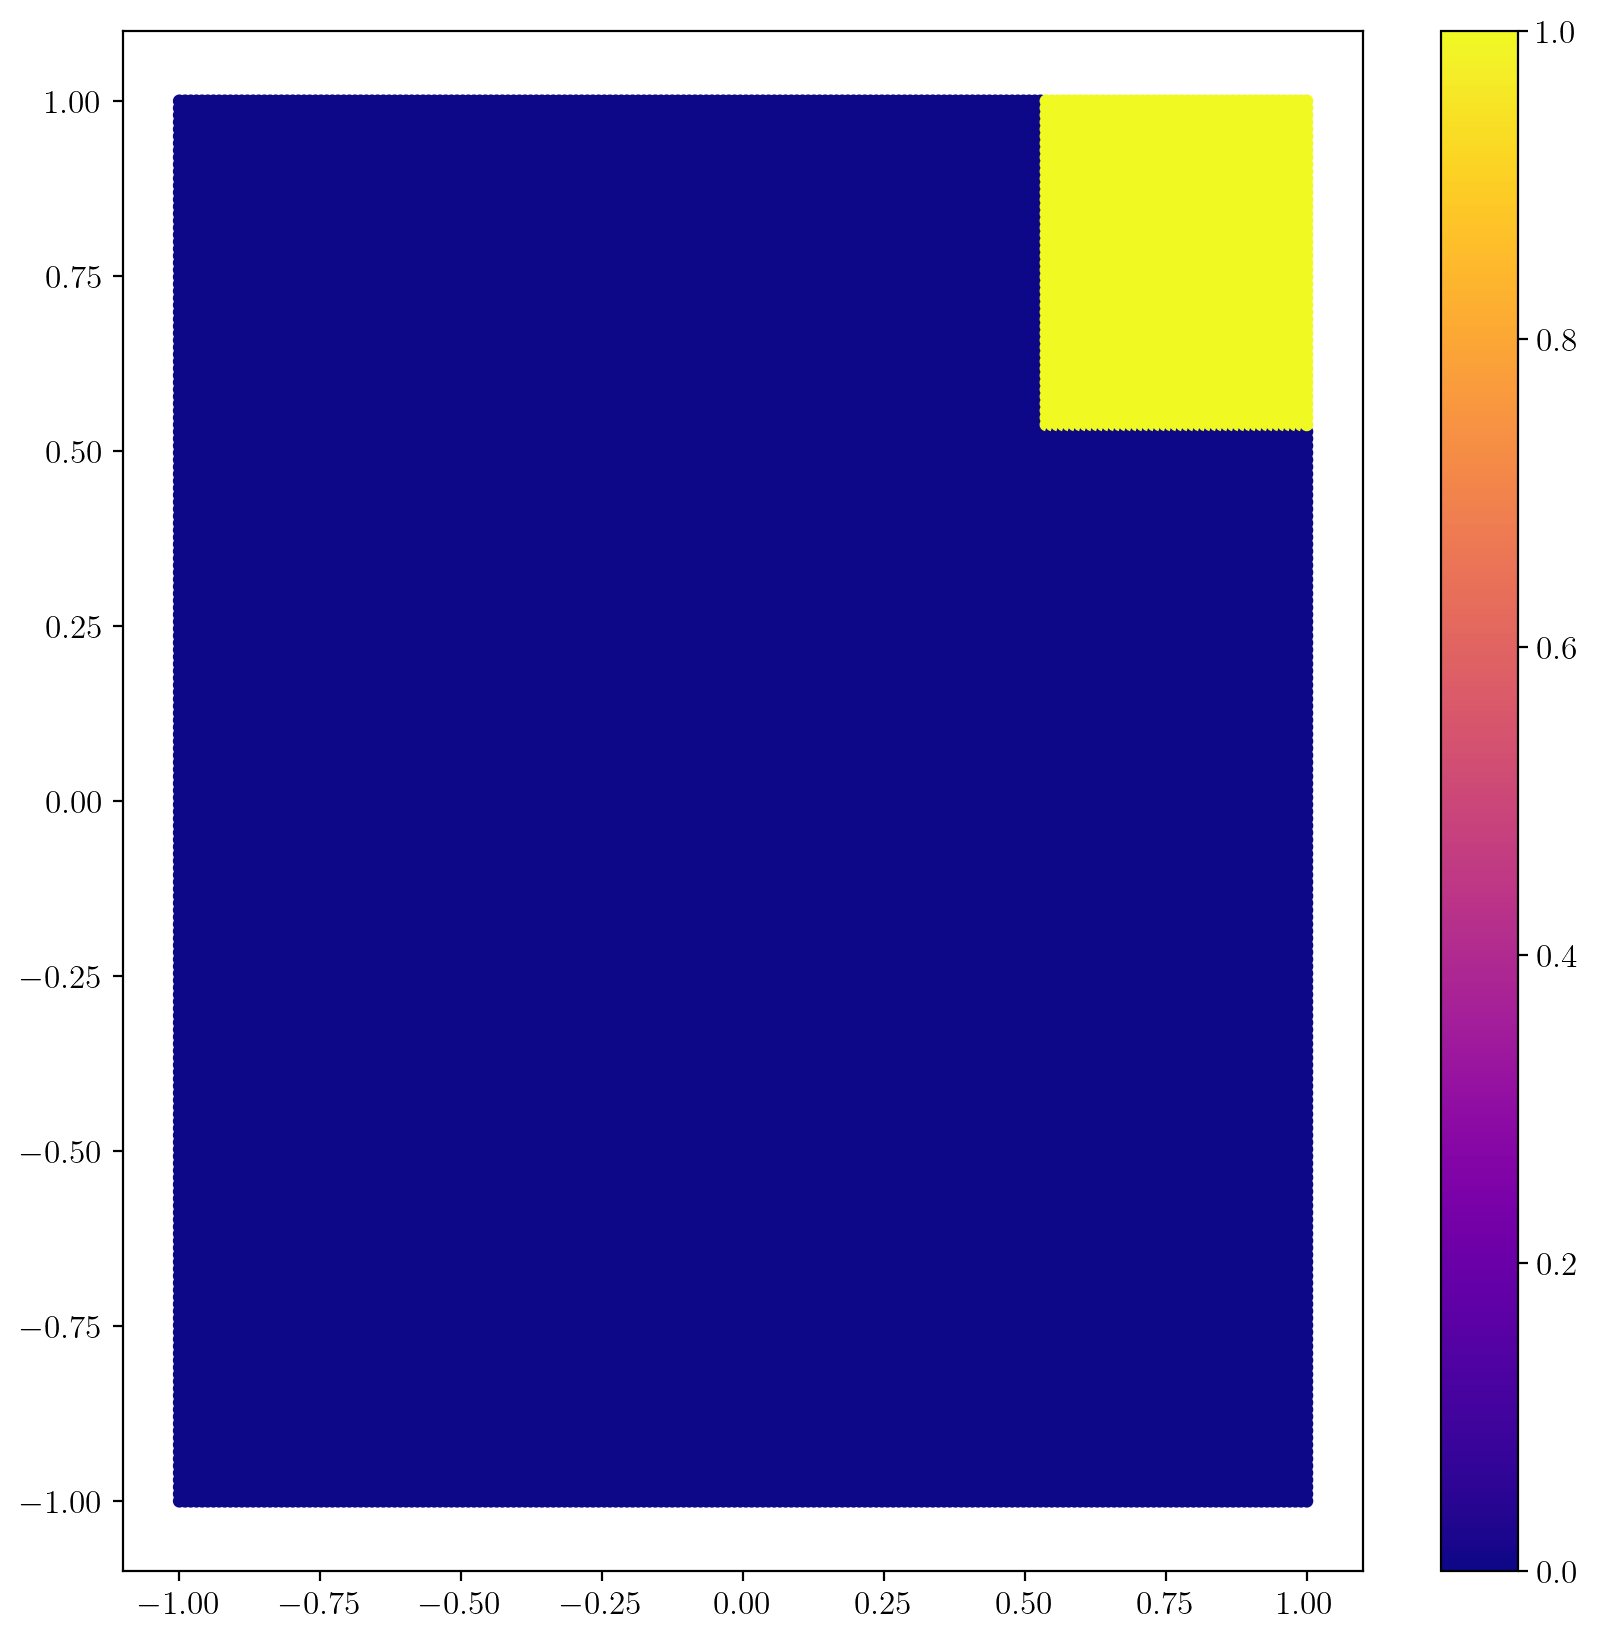

In [9]:
alt = np.logical_and(*[slc.dot(H.n) - H.c < 0 for H in S.g.null_hypos])
plt.figure(figsize=(10, 10))
plt.scatter(slc_ravel[:, plot_dims[0]], slc_ravel[:, plot_dims[1]], c=alt, s=14)
plt.colorbar()
plt.show()

In [98]:
alt_space = (slc[..., 1] > slc[..., 0]) & (slc[..., 2] > slc[..., 0])
sym = slc[..., 2] > slc[..., 1]


def alt_and_sym(f):
    f[alt_space] = np.nan
    f2d = f.reshape((nx, ny))
    f2d[sym] = f2d.T[sym]

In [99]:
lamstar = bootstrap_cvs[idx, 0]
alt_and_sym(lamstar)
alt_and_sym(tb)

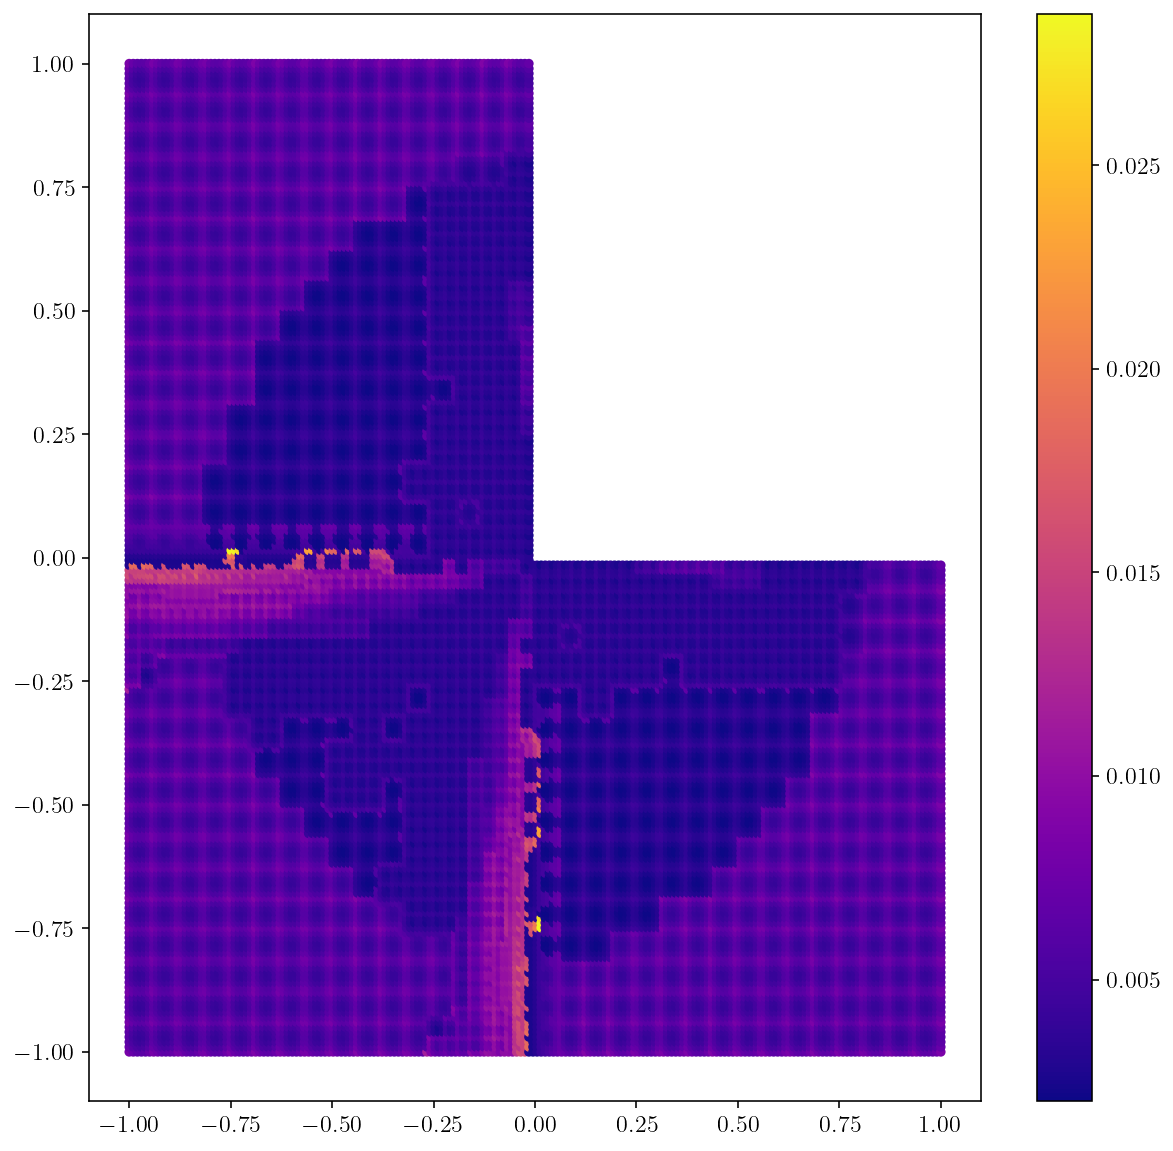

In [100]:
plt.figure(figsize=(10, 10))
plt.scatter(full_grid[:, plot_dims[0]], full_grid[:, plot_dims[1]], c=tb, s=14)
plt.colorbar()
plt.show()

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_42087/1795720621.py:12: UserWarning: No contour levels were found within the data range.
  plt.contour(


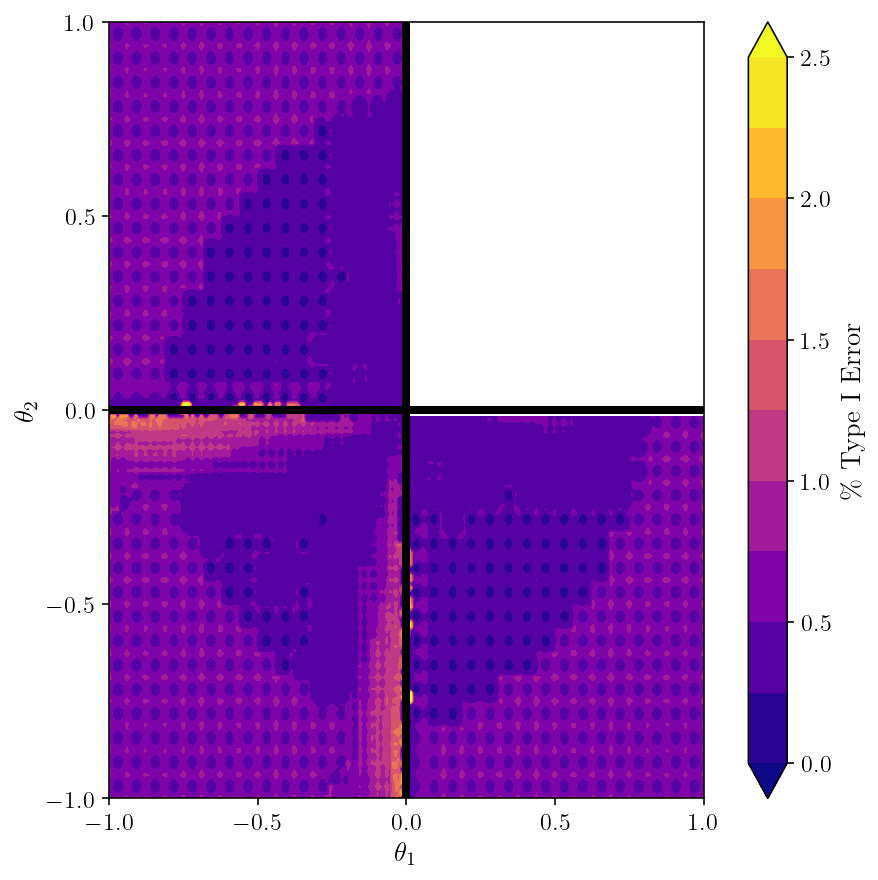

In [130]:
x = full_grid[:, plot_dims[0]].reshape((nx, ny))
y = full_grid[:, plot_dims[1]].reshape((nx, ny))
z = lamstar.reshape((nx, ny))
levels = np.linspace(0, 0.2, 11)

z = tb.reshape((nx, ny)) * 100
levels = np.linspace(0, 2.5, 11)

cmap = None
plt.figure(figsize=(6, 6), constrained_layout=True)
cbar_target = plt.contourf(x, y, z, levels=levels, extend="both", cmap=cmap)
plt.contour(
    x,
    y,
    z * 100,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cbar_target)
cbar.set_label("\% Type I Error")
plt.axvline(x=0, color="k", linestyle="-", linewidth=4)
plt.axhline(y=0, color="k", linestyle="-", linewidth=4)
plt.xlabel(r"$\theta_1$")
plt.xticks(np.linspace(-1, 1, 5))
plt.ylabel(r"$\theta_2$")
plt.yticks(np.linspace(-1, 1, 5))
plt.show()

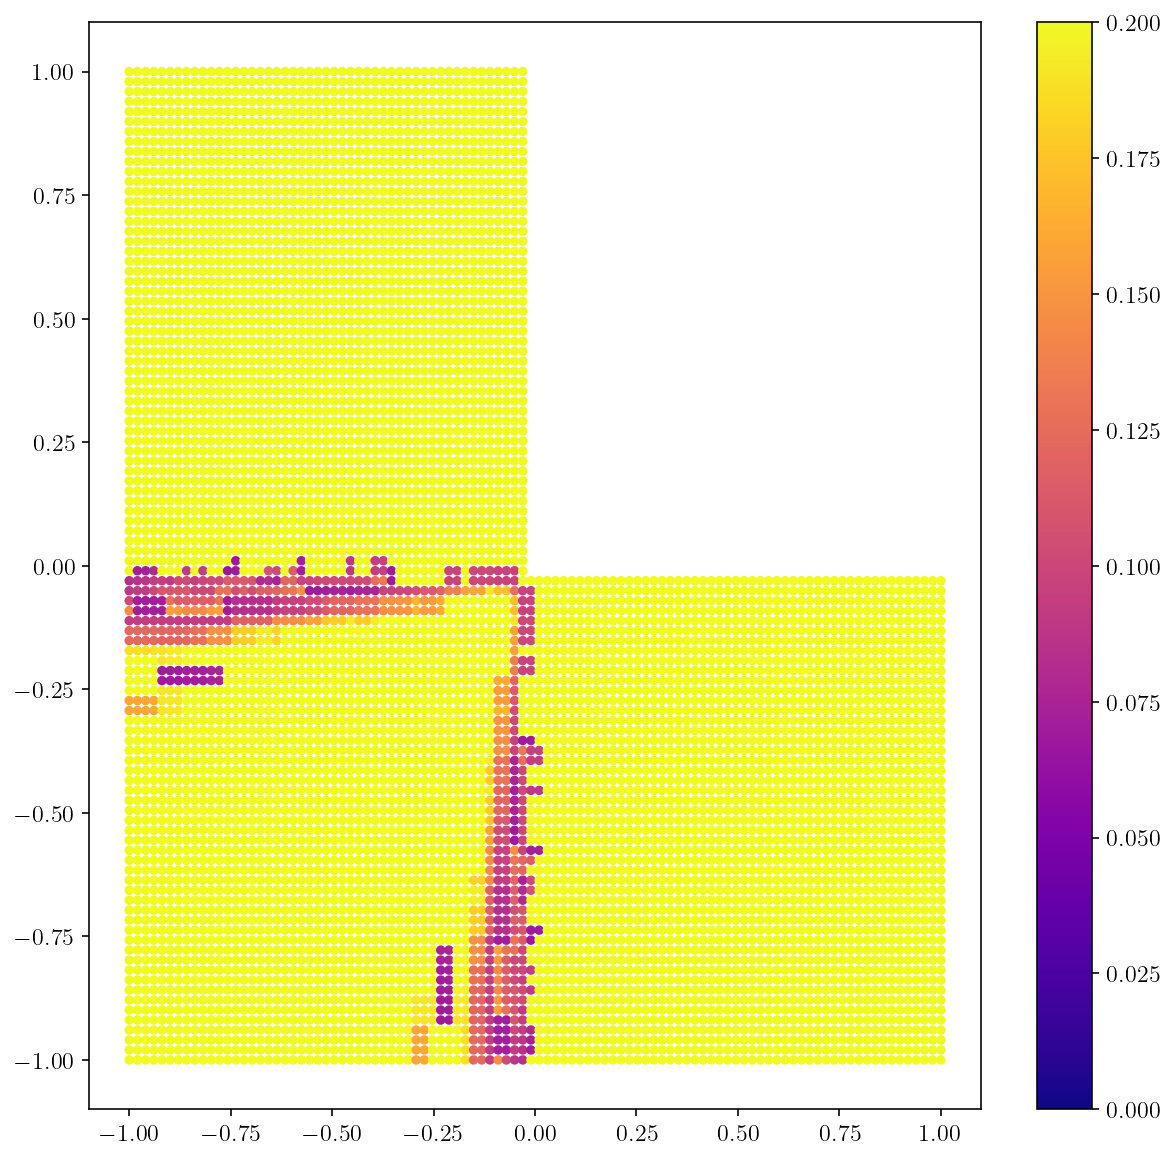

In [93]:
plt.figure(figsize=(10, 10))
plt.scatter(
    full_grid[:, plot_dims[0]],
    full_grid[:, plot_dims[1]],
    c=lamstar,
    vmin=0,
    vmax=0.2,
    s=14,
)
plt.colorbar()
plt.show()